# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




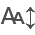

In [166]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [167]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [168]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

In [169]:
## define SPARQL enpoint
endpoint_url = "https://ag10gz6eypmkc7tx.allegrograph.cloud/repositories/novelists"

In [170]:
basic_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?s ?label ?birthDate ?genderLabel ?countryLabel ?continentLabel
WHERE {
  GRAPH <https://github.com/mariaponomarova/novelists/blob/main/Wikidata/graph/imported-data.md> {
    ?s wdt:P21 ?gender ;
       rdfs:label ?label ;
       wdt:P569 ?birthDate ;
       wdt:P27 ?country .

    ?gender rdfs:label ?genderLabel .
    ?country rdfs:label ?countryLabel .
    ?country wdt:P30 ?continent .
    ?continent rdfs:label ?continentLabel .

    FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538 ))
  }
}
"""
basic_data = spqf.get_json_sparql_result(endpoint_url, basic_query)
basic_df = pd.json_normalize(basic_data['results']['bindings'])


In [171]:
occupation_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?s ?occupationLabel
WHERE {
  GRAPH <https://github.com/mariaponomarova/novelists/blob/main/Wikidata/graph/imported-data.md> {
    ?s wdt:P106 ?occupation .
    ?occupation rdfs:label ?occupationLabel .
  }
}
"""
occupation_data = spqf.get_json_sparql_result(endpoint_url, occupation_query)
occupation_df = pd.json_normalize(occupation_data['results']['bindings'])


In [172]:
field_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?s ?fieldLabel
WHERE {
  GRAPH <https://github.com/mariaponomarova/novelists/blob/main/Wikidata/graph/imported-data.md> {
    ?s wdt:P101 ?field .
    ?field rdfs:label ?fieldLabel .
  }
}
"""
field_data = spqf.get_json_sparql_result(endpoint_url, field_query)
field_df = pd.json_normalize(field_data['results']['bindings'])


In [174]:
basic_clean = basic_df.rename(columns={
    's.value': 's',
    'label.value': 'label',
    'birthDate.value': 'birthDate',
    'genderLabel.value': 'gender',
    'countryLabel.value': 'country',
    'continentLabel.value': 'continent'
})

occupation_clean = occupation_df.rename(columns={
    's.value': 's',
    'occupationLabel.value': 'occupationLabel'
})

field_clean = field_df.rename(columns={
    's.value': 's',
    'fieldLabel.value': 'fieldLabel'
})

occupation_agg = occupation_clean.groupby('s')['occupationLabel'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()
field_agg = field_clean.groupby('s')['fieldLabel'].apply(lambda x: ', '.join(sorted(set(x)))).reset_index()

merged_df = basic_clean.merge(occupation_agg, on='s', how='left').merge(field_agg, on='s', how='left')
merged_df.head()

,s.type,s,label.type,label,birthDate.type,birthDate,genderLabel.type,gender,countryLabel.type,country,continentLabel.type,continent,occupationLabel,fieldLabel
0,uri,http://www.wikidata.org/entity/Q106854777,literal,Galina Nikolaevna Sokolova,literal,1935,literal,female,literal,Soviet Union,literal,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc..."
1,uri,http://www.wikidata.org/entity/Q106854777,literal,Galina Nikolaevna Sokolova,literal,1935,literal,female,literal,Soviet Union,literal,Asia,"editing staff, sociologist","economic sociology, philosophy, sociology, soc..."
2,uri,http://www.wikidata.org/entity/Q5407601,literal,Lee Wilkinson,literal,1901,literal,female,literal,United Kingdom,literal,Europe,NaN,NaN
3,uri,http://www.wikidata.org/entity/Q16733524,literal,Laureen Nussbaum,literal,1927,literal,female,literal,Germany,literal,Europe,"researcher, university teacher, writer","linguistics, literature"
4,uri,http://www.wikidata.org/entity/Q4899469,literal,Beverly Barton,literal,1946,literal,female,literal,United States,literal,North America,"novelist, writer",NaN


## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [175]:
df_p = merged_df.rename(columns={
    's': 'personUri',
    'label': 'personLabel',
    'birthDate': 'birthYear',
    'country': 'countries',
    'continent': 'continents',
    'occupationLabel': 'occupations',
    'fieldLabel': 'fields'
})

df_p = df_p.drop(columns=[col for col in df_p.columns if col.endswith('.type')])

# convert birthDate to just the year
df_p['birthYear'] = pd.to_datetime(df_p['birthYear'], errors='coerce').dt.year

df_p.head()


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc..."
1,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Asia,"editing staff, sociologist","economic sociology, philosophy, sociology, soc..."
2,http://www.wikidata.org/entity/Q5407601,Lee Wilkinson,1901,female,United Kingdom,Europe,NaN,NaN
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature"
4,http://www.wikidata.org/entity/Q4899469,Beverly Barton,1946,female,United States,North America,"novelist, writer",NaN


In [188]:
# Drop rows with missing in occupations or fields
df_p = df_p.dropna(subset=['occupations', 'fields'])
len(df_p)

10516

In [186]:
#we could see there were some duplicates
df_p = df_p.drop_duplicates(subset='personUri')
print(df_p['personUri'].duplicated().sum())  # how many duplicates left

0


In [177]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [190]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10516 entries, 0 to 43721
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    10516 non-null  object
 1   personLabel  10516 non-null  object
 2   birthYear    10516 non-null  int64 
 3   gender       10516 non-null  object
 4   countries    10516 non-null  object
 5   continents   10516 non-null  object
 6   occupations  10516 non-null  object
 7   fields       10516 non-null  object
 8   contCode     10516 non-null  object
dtypes: int64(1), object(8)
memory usage: 821.6+ KB


In [189]:
### Store to CSV

f_path = 'data/df_continent_occupations_fields.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [191]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0            Europe
3            Europe
8     North America
9            Europe
12           Europe
Name: continents, dtype: object


In [192]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                    0
continents           
Europe           7425
North America    2254
Asia              434
South America     206
Oceania            99
Africa             84
Eurasia            13
Central America     1


In [193]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [194]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [195]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica


In [196]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Missing              1
Eurasia             13
Africa              84
Oceania             99
SouthAmerica       206
Asia               434
NorthAmerica      2254
Europe            7425


In [197]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
47,http://www.wikidata.org/entity/Q87444480,Anastasia Marchenko,1830,female,Russian Empire,North America,"poet, writer",literature,NorthAmerica
139,http://www.wikidata.org/entity/Q4203038,Ira Yan,1869,female,Russian Empire,North America,"painter, translator, writer","art of painting, literature, translation",NorthAmerica
165,http://www.wikidata.org/entity/Q7017018,Olga Shapir,1850,female,Russian Empire,North America,"feminist, writer","feminism, literature",NorthAmerica
342,http://www.wikidata.org/entity/Q7017910,Sofia Soboleva,1840,female,Russian Empire,North America,"journalist, writer","Russian literature, children's and youth liter...",NorthAmerica
405,http://www.wikidata.org/entity/Q15069716,Elizabeth Trubetskaya,1834,female,Russian Empire,North America,"composer, writer","literature, music, philanthropy, politics",NorthAmerica
422,http://www.wikidata.org/entity/Q84311073,Lydia Tugan-Baranovskaya,1869,female,Russian Empire,North America,"editing staff, writer","children's and youth literature, literature, p...",NorthAmerica
732,http://www.wikidata.org/entity/Q26208095,Maria Bezobrazova,1857,female,Russian Empire,North America,"historian, journalist, philosopher, teacher, w...","pedagogy, philosophy",NorthAmerica


In [198]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Eurasia              9
Europe             106
NorthAmerica       302


In [199]:
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
292,http://www.wikidata.org/entity/Q15512040,Gertrude Crampton,1909,female,United States,North America,writer,"children's and youth literature, children's bo...",NorthAmerica
301,http://www.wikidata.org/entity/Q3144842,Hélène Rioux,1949,female,Canada,North America,"novelist, translator, writer","literature, translation from English, translat...",NorthAmerica
308,http://www.wikidata.org/entity/Q51274356,Leena Löfstedt,1937,female,Finland,Europe,"linguist, philologist, philosopher, romanist, ...","Romance studies, history of literature, philol...",Europe
309,http://www.wikidata.org/entity/Q7422495,Sarah Knowles Bolton,1841,female,United States,North America,"historian, writer",literature,NorthAmerica


In [200]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
338,http://www.wikidata.org/entity/Q9255816,Eugenia Siemaszkiewicz,1932,female,Poland,Europe,"translator, writer","literature, translating activity",Europe
342,http://www.wikidata.org/entity/Q7017910,Sofia Soboleva,1840,female,Russian Empire,North America,"journalist, writer","Russian literature, children's and youth liter...",NorthAmerica
344,http://www.wikidata.org/entity/Q9256766,Ewa Maria Ostrowska,1938,female,Poland,Europe,"opinion journalist, writer","literature, opinion journalism",Europe
345,http://www.wikidata.org/entity/Q77959306,Eva Formánková,1931,female,Czechoslovakia,Europe,"editing staff, literary critic, philosopher, t...","literary criticism, philosophy, translation fr...",Europe
348,http://www.wikidata.org/entity/Q4768755,Anne Roiphe,1935,female,United States,North America,"essayist, journalist, novelist, writer",essay,NorthAmerica
350,http://www.wikidata.org/entity/Q15451040,Toni Kienlechner,1919,female,Germany,Europe,"journalist, translator, writer","journalism, literature, translation",Europe
351,http://www.wikidata.org/entity/Q115254669,Nicole Lacelle,1947,female,Canada,North America,"publisher, writer","education, feminism, literature, politics, pub...",NorthAmerica


In [201]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("novelist|philosopher", na=False))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  4466 

0    http://www.wikidata.org/entity/Q106854777
3     http://www.wikidata.org/entity/Q16733524
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe
9,http://www.wikidata.org/entity/Q12002158,Věra Plívová-Šimková,1934,female,Czech Republic,Europe,"director, film director, screenwriter, writer","children's film, film, literature, serial film",Europe
14,http://www.wikidata.org/entity/Q6105466,J. E. Franklin,1937,female,United States,North America,"playwright, university teacher, writer","drama, literature",NorthAmerica
21,http://www.wikidata.org/entity/Q17351107,Tatjana Pregl Kobe,1946,female,Slovenia,Europe,"art critic, art historian, critic, essayist, j...","Q16520492, art history, essay, journalism, lit...",Europe


### Distribution des continents: représentation graphique

In [202]:
#drop all the rows where the continent was 'Missing'
df_p = df_p[df_p['contCode'] != 'Missing']

### Regrouper et compter

df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Eurasia,13,0.12
Africa,84,0.80
Oceania,99,0.94
SouthAmerica,206,1.96
Asia,434,4.13
NorthAmerica,2254,21.44
Europe,7425,70.61


In [203]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,NorthAmerica,Asia,SouthAmerica,Oceania,Africa,Eurasia
frequence,70.61,21.44,4.13,1.96,0.94,0.8,0.12


In [204]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


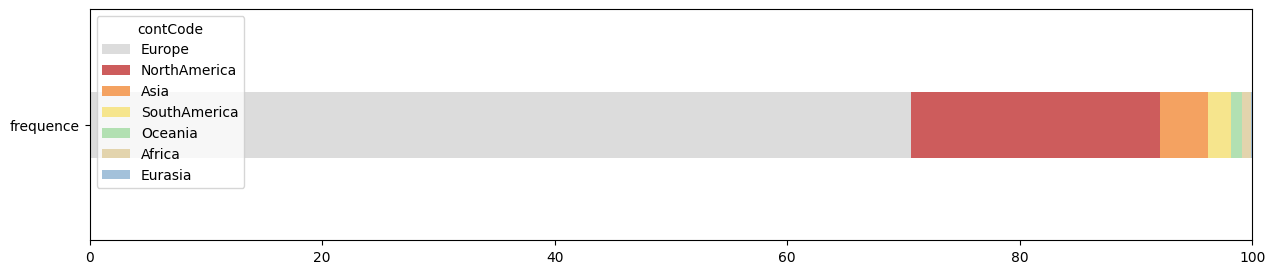

In [205]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [210]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [211]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [212]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica,1926-1950


In [213]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1751-1775     185
1776-1800     231
1801-1825     459
1826-1850     585
1851-1875    1026
1876-1900    1584
1901-1925    2172
1926-1950    4273
dtype: int64


### Comparer période et continent

In [214]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,0,5,0,162,17,0,1,185
1776-1800,0,4,2,196,29,0,0,231
1801-1825,0,3,2,361,91,1,1,459
1826-1850,0,2,1,437,136,2,7,585
1851-1875,1,25,4,801,189,3,3,1026
1876-1900,7,62,4,1253,227,13,18,1584
1901-1925,17,111,0,1533,436,25,50,2172
1926-1950,59,222,0,2682,1129,55,126,4273
Total,84,434,13,7425,2254,99,206,10515


In [215]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,162,0,17,5,0,0,1,185
1776-1800,196,2,29,4,0,0,0,231
1801-1825,361,2,91,3,0,1,1,459
1826-1850,437,1,136,2,0,2,7,585
1851-1875,801,4,189,25,1,3,3,1026
1876-1900,1253,4,227,62,7,13,18,1584
1901-1925,1533,0,436,111,17,25,50,2172
1926-1950,2682,0,1129,222,59,55,126,4273
Total,7425,13,2254,434,84,99,206,10515


In [216]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


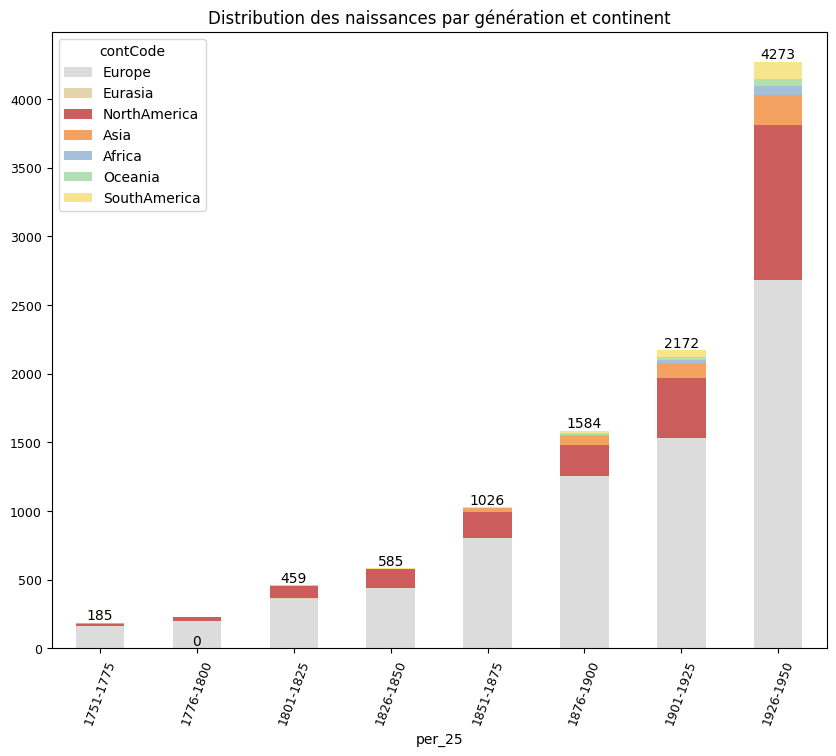

In [217]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [218]:
ddf

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,162,0,17,5,0,0,1,185
1776-1800,196,2,29,4,0,0,0,231
1801-1825,361,2,91,3,0,1,1,459
1826-1850,437,1,136,2,0,2,7,585
1851-1875,801,4,189,25,1,3,3,1026
1876-1900,1253,4,227,62,7,13,18,1584
1901-1925,1533,0,436,111,17,25,50,2172
1926-1950,2682,0,1129,222,59,55,126,4273
Total,7425,13,2254,434,84,99,206,10515


In [219]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,437,1,136,2,0,2,7
1851-1875,801,4,189,25,1,3,3
1876-1900,1253,4,227,62,7,13,18
1901-1925,1533,0,436,111,17,25,50
1926-1950,2682,0,1129,222,59,55,126
Total,7425,13,2254,434,84,99,206


In [220]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 6 , 7 ), effectif: 20155 , nombre max. facteurs: 5


In [221]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 300.31 , dof : 30
p-value : 2.2988727947526628e-46
phi2 = inertie (variance totale) : 0.014900107768845258
Cramer:  0.0545895736727175


In [222]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,410,1,127,25,5,6,12
1851-1875,719,1,223,44,9,10,21
1876-1900,1111,2,344,67,13,15,32
1901-1925,1523,2,471,92,18,21,44
1926-1950,2996,5,927,181,36,42,87
Total,7372,11,2280,447,88,103,214


In [223]:
D

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,437,1,136,2,0,2,7
1851-1875,801,4,189,25,1,3,3
1876-1900,1253,4,227,62,7,13,18
1901-1925,1533,0,436,111,17,25,50
1926-1950,2682,0,1129,222,59,55,126
Total,7425,13,2254,434,84,99,206


In [224]:


### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))



contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1826-1850      27        0             9   -23      -5       -4            -5
1851-1875      82        3           -34   -19      -8       -7           -18
1876-1900     142        2          -117    -5      -6       -2           -14
1901-1925      10       -2           -35    19      -1        4             6
1926-1950    -314       -5           202    41      23       13            39
Total          53        2           -26   -13      -4       -4            -8


In [225]:


### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,1.33,0.45,0.81,-4.58,-2.21,-1.55,-1.42
1851-1875,3.04,2.72,-2.25,-2.81,-2.58,-2.22,-3.91
1876-1900,4.27,1.73,-6.29,-0.64,-1.71,-0.63,-2.51
1901-1925,0.26,-1.54,-1.61,1.95,-0.26,0.82,0.88
1926-1950,-5.73,-2.16,6.65,3.01,3.92,2.05,4.19
Total,0.61,0.45,-0.55,-0.60,-0.39,-0.37,-0.54


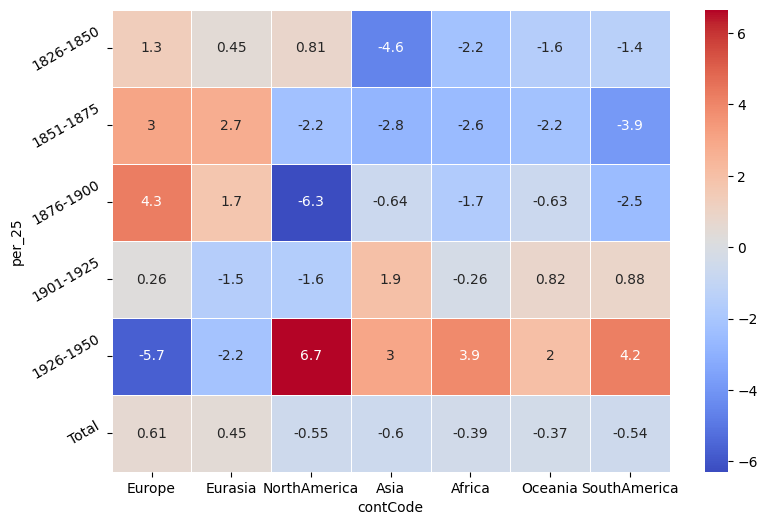

In [226]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [227]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1826-1850,1,136,2,0,2,7
1851-1875,4,189,25,1,3,3
1876-1900,4,227,62,7,13,18
1901-1925,0,436,111,17,25,50
1926-1950,0,1129,222,59,55,126
Total,13,2254,434,84,99,206


In [228]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 105.77 , dof : 25
p-value : 6.586048191459413e-12
phi2 = inertie (variance totale) : 0.00524770082113427
Cramer:  0.05925819941751423


In [229]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1826-1850,437,2,1,136,7
1851-1875,801,25,4,189,3
1876-1900,1253,62,4,227,18
1901-1925,1533,111,0,436,50
1926-1950,2682,222,0,1129,126
Total,7425,434,13,2254,206


In [230]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 15.08 , dof : 5
p-value : 0.0100085101096196
phi2 = inertie (variance totale) : 0.0007484104026697554
Cramer:  0.03264653215921741


## Continent et genre

In [231]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica,1926-1950
9,http://www.wikidata.org/entity/Q12002158,Věra Plívová-Šimková,1934,female,Czech Republic,Europe,"director, film director, screenwriter, writer","children's film, film, literature, serial film",Europe,1926-1950
12,http://www.wikidata.org/entity/Q2978445,Claudie Hunzinger,1940,female,France,Europe,"novelist, plastic artist, visual artist, writer","literature, prose, visual arts",Europe,1926-1950


In [232]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,14,79,3,1155,575,37,36,1899
male,70,355,10,6267,1676,62,170,8610
Total,84,434,13,7422,2251,99,206,10509


### Créer la fonction

In [233]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

In [234]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,14,79,3,1155,575,37,36
male,70,355,10,6267,1676,62,170


Chi2 : 141.78 , dof : 6
p-value : 4.221370429748566e-28
phi2 = inertie (variance totale) : 0.007034436155568999
Cramer:  0.11615164139270664


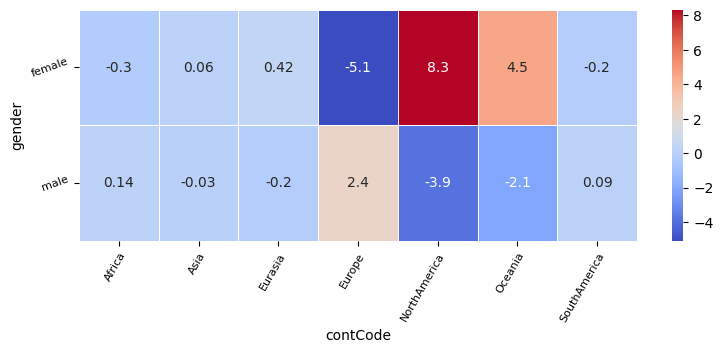

In [235]:
bivariee_stats(D)

### Genre et continent par époque

In [236]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950,Europe_female
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica,1926-1950,NorthAmerica_female
9,http://www.wikidata.org/entity/Q12002158,Věra Plívová-Šimková,1934,female,Czech Republic,Europe,"director, film director, screenwriter, writer","children's film, film, literature, serial film",Europe,1926-1950,Europe_female
12,http://www.wikidata.org/entity/Q2978445,Claudie Hunzinger,1940,female,France,Europe,"novelist, plastic artist, visual artist, writer","literature, prose, visual arts",Europe,1926-1950,Europe_female


In [237]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,1,4,0,0,20,142,4,13,0,0,0,1,185
1776-1800,0,0,0,4,1,1,22,174,4,25,0,0,0,0,231
1801-1825,0,0,0,3,1,1,37,324,17,74,1,0,0,1,459
1826-1850,0,0,0,2,0,1,58,379,28,108,0,2,1,6,585
1851-1875,0,1,0,25,1,3,113,688,41,148,1,2,1,2,1026
1876-1900,1,6,7,55,0,4,158,1093,53,174,5,8,2,16,1582
1901-1925,3,14,17,94,0,0,253,1279,83,353,10,15,7,43,2171
1926-1950,10,49,54,168,0,0,494,2188,345,781,20,35,25,101,4270
Total,14,70,79,355,3,10,1155,6267,575,1676,37,62,36,170,10509


In [238]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[6:-1,:-1].copy(deep=True)
D = D.loc[(D.sum(axis=1) != 0), (D.sum(axis=0) != 0)]

D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,
1901-1925,3,14,17,94,253,1279,83,353,10,15,7,43
1926-1950,10,49,54,168,494,2188,345,781,20,35,25,101


Chi2 : 69.58 , dof : 11
p-value : 1.467171972660351e-10
phi2 = inertie (variance totale) : 0.003452317233143733
Cramer:  0.10393698142802743


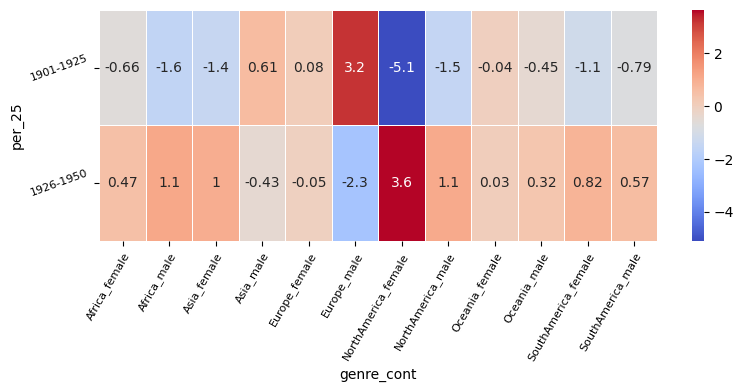

In [239]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [240]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

1155


In [241]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
United Kingdom                                 180
France                                         143
Germany                                         91
Poland                                          91
Czechoslovakia                                  79
Soviet Union                                    57
United Kingdom of Great Britain and Ireland     55
Sweden                                          47
Austria                                         33
Spain                                           30
dtype: int64


In [242]:
print(df_pef[df_pef.per_25 == '1926-1950'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
United Kingdom    74
France            74
Poland            46
Germany           30
Czechoslovakia    28
Soviet Union      26
Italy             22
Sweden            21
Czech Republic    16
Spain             13
dtype: int64


In [243]:
fff = df_pef[(df_pef.per_25 == '1926-1950') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

30


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female
264,http://www.wikidata.org/entity/Q1513734,Gerlind Reinshagen,1926,female,Germany,Europe,"playwright, poet, writer","children's and youth literature, drama, litera...",Europe,1926-1950,Europe_female
382,http://www.wikidata.org/entity/Q52162443,Sigrid Früh,1935,female,Germany,Europe,"editor, ethnographer, folklorist, germanist, s...","ethnography, literature, philology",Europe,1926-1950,Europe_female
819,http://www.wikidata.org/entity/Q1497733,Geertje Suhr,1943,female,Germany,Europe,"novelist, poet, writer",German studies,Europe,1926-1950,Europe_female
1077,http://www.wikidata.org/entity/Q1456539,Hannelies Taschau,1937,female,Germany,Europe,"novelist, poet, screenwriter, writer",German-language literature,Europe,1926-1950,Europe_female


## Continent et discipline

In [244]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950,Europe_female
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica,1926-1950,NorthAmerica_female
9,http://www.wikidata.org/entity/Q12002158,Věra Plívová-Šimková,1934,female,Czech Republic,Europe,"director, film director, screenwriter, writer","children's film, film, literature, serial film",Europe,1926-1950,Europe_female
12,http://www.wikidata.org/entity/Q2978445,Claudie Hunzinger,1940,female,France,Europe,"novelist, plastic artist, visual artist, writer","literature, prose, visual arts",Europe,1926-1950,Europe_female


In [248]:
def code_discipline(col1, col2):
    if 'novelist' in col1 or 'literature' in col2:
        output = 'novelist'
    elif 'philosopher' in col1 or 'philosophy' in col2:
        output = 'philosopher'
    else:
        output = 'other'
    return output


In [249]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950,Europe_female,philosopher
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female,novelist
8,http://www.wikidata.org/entity/Q3759051,Gayl Jones,1949,female,United States,North America,"novelist, poet, university teacher, writer",African American literature,NorthAmerica,1926-1950,NorthAmerica_female,novelist
9,http://www.wikidata.org/entity/Q12002158,Věra Plívová-Šimková,1934,female,Czech Republic,Europe,"director, film director, screenwriter, writer","children's film, film, literature, serial film",Europe,1926-1950,Europe_female,novelist
12,http://www.wikidata.org/entity/Q2978445,Claudie Hunzinger,1940,female,France,Europe,"novelist, plastic artist, visual artist, writer","literature, prose, visual arts",Europe,1926-1950,Europe_female,novelist


In [251]:
df_p.groupby('code_discipline').size()

code_discipline
novelist       6719
philosopher    3796
dtype: int64

In [252]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
novelist,59,251,7,4705,1488,71,132,6713
philosopher,25,183,6,2717,763,28,74,3796
Total,84,434,13,7422,2251,99,206,10509


In [253]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
novelist,0.9,3.7,0.1,70.1,22.2,1.1,2.0,100.0
philosopher,0.7,4.8,0.2,71.6,20.1,0.7,1.9,100.0
Total,0.8,4.1,0.1,70.6,21.4,0.9,2.0,100.0


In [254]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


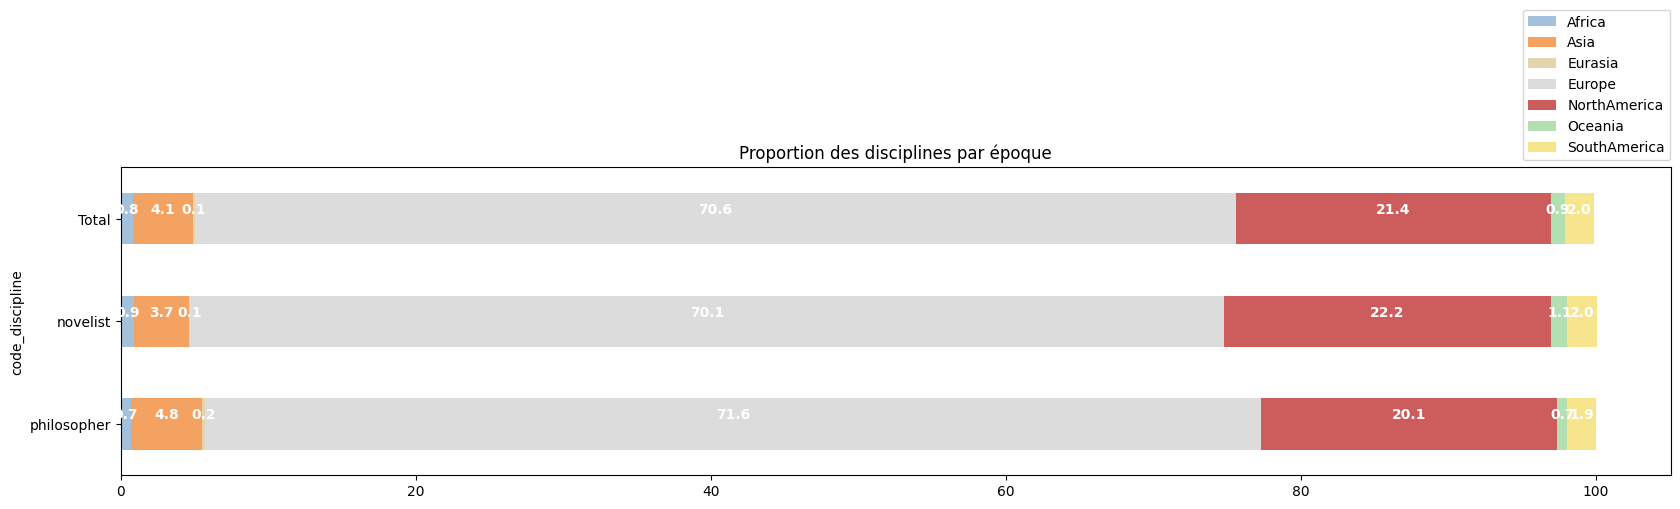

In [255]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,4), title='Proportion des disciplines par époque',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [256]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
novelist,59,251,7,4705,1488,71,132
philosopher,25,183,6,2717,763,28,74


Chi2 : 17.14 , dof : 6
p-value : 0.008774604541166891
phi2 = inertie (variance totale) : 0.0008505184626688491
Cramer:  0.040388021426229034


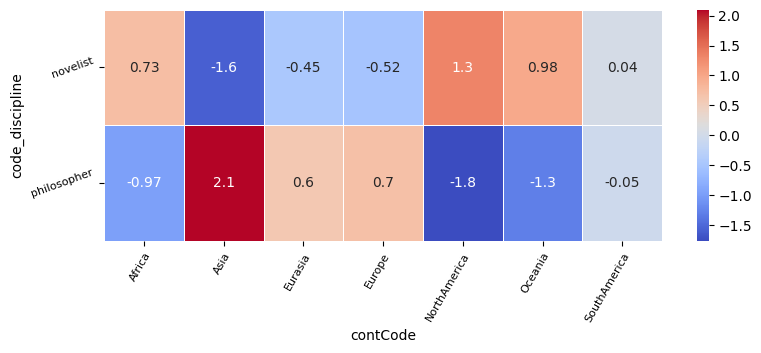

In [257]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [258]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950,Europe_female,philosopher
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female,novelist


In [259]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q106854777,Galina Nikolaevna Sokolova,1935,female,Soviet Union,Europe,"editing staff, sociologist","economic sociology, philosophy, sociology, soc...",Europe,1926-1950,Europe_female,philosopher,Europe_philosopher
3,http://www.wikidata.org/entity/Q16733524,Laureen Nussbaum,1927,female,Germany,Europe,"researcher, university teacher, writer","linguistics, literature",Europe,1926-1950,Europe_female,novelist,Europe_novelist


In [260]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_novelist,Africa_philosopher,Asia_novelist,Asia_philosopher,Eurasia_novelist,Eurasia_philosopher,Europe_novelist,Europe_philosopher,NorthAmerica_novelist,NorthAmerica_philosopher,Oceania_novelist,Oceania_philosopher,SouthAmerica_novelist,SouthAmerica_philosopher,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,3,2,0,0,88,74,11,6,0,0,1,0,185
1776-1800,0,0,1,3,2,0,129,67,16,13,0,0,0,0,231
1801-1825,0,0,1,2,2,0,252,109,66,25,1,0,0,1,459
1826-1850,0,0,1,1,0,1,300,137,96,40,2,0,7,0,585
1851-1875,0,1,6,19,2,2,559,242,133,56,2,1,2,1,1026
1876-1900,5,2,31,31,1,3,860,391,152,75,12,1,13,5,1582
1901-1925,9,8,70,41,0,0,976,556,290,146,18,7,28,22,2171
1926-1950,45,14,138,84,0,0,1541,1141,724,402,36,19,81,45,4270
Total,59,25,251,183,7,6,4705,2717,1488,763,71,28,132,74,10509


In [261]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


disc_cont,Africa_novelist,Africa_philosopher,Asia_novelist,Asia_philosopher,Eurasia_novelist,Eurasia_philosopher,Europe_novelist,Europe_philosopher,NorthAmerica_novelist,NorthAmerica_philosopher,Oceania_novelist,Oceania_philosopher,SouthAmerica_novelist,SouthAmerica_philosopher
per_25,,,,,,,,,,,,,,
1876-1900,5,2,31,31,1,3,860,391,152,75,12,1,13,5
1901-1925,9,8,70,41,0,0,976,556,290,146,18,7,28,22
1926-1950,45,14,138,84,0,0,1541,1141,724,402,36,19,81,45


Chi2 : 242.03 , dof : 26
p-value : 6.359201653245602e-37
phi2 = inertie (variance totale) : 0.01200820847249436
Cramer:  0.12281378520311545


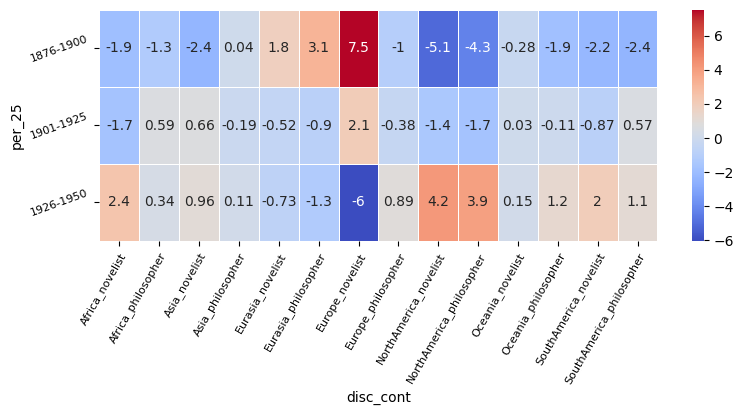

In [262]:
## Appliquer la fonction
bivariee_stats(D)